In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from datetime import datetime
from pyproj import CRS
import string
from datetime import datetime
import osmnx as ox
import scipy
from sklearn import preprocessing, cluster
from geopy import distance
from sklearn.base import BaseEstimator, TransformerMixin
import category_encoders as ce
import math
import statistics
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
import random
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest, VotingClassifier
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,8)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Load and Check Data

In [2]:
full_data = pd.read_excel('shanghai_gps.xlsx', skiprows=6, header=0)
full_data.columns = ['_'.join(name.lower().translate(str.maketrans(' ', ' ', string.punctuation)).split()) for name in full_data.columns]

In [3]:
len(full_data.end_time_in_seconds.unique())

10392

In [4]:
full_data.describe()

,uid,date_in_days,week,start_time_in_seconds,end_time_in_seconds,start_longitude,start_latitude,end_longitude,end_latitude,activitytrip,trip_mode,start_location,end_location,activity_type
count,10408.000000,10408.000000,10408.000000,1.040800e+04,1.040800e+04,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000
mean,2842.034493,16495.592045,3.176018,1.425239e+09,1.425243e+09,121.422001,31.192084,121.422014,31.191786,0.471464,1.880765,-0.231168,-0.218678,1.240680
std,2293.963747,197.220231,1.782481,1.704018e+07,1.704071e+07,0.133439,0.141343,0.133523,0.142475,0.499209,2.488351,0.797554,0.802387,1.389195
min,146.000000,15996.000000,0.000000,1.382053e+09,1.382053e+09,120.000050,30.000058,120.000079,30.000203,0.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,646.000000,16234.000000,2.000000,1.402620e+09,1.402621e+09,121.377204,31.153523,121.378311,31.153198,0.000000,0.000000,-1.000000,-1.000000,0.000000
50%,802.000000,16610.000000,3.000000,1.435149e+09,1.435152e+09,121.433450,31.209346,121.433493,31.209479,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5202.000000,16644.000000,5.000000,1.438097e+09,1.438098e+09,121.484058,31.265852,121.484527,31.265647,1.000000,4.000000,0.000000,0.000000,2.000000
max,5281.000000,16773.000000,6.000000,1.449234e+09,1.449235e+09,122.062761,31.999985,122.054907,31.999998,1.000000,8.000000,1.000000,1.000000,5.000000


In [5]:
full_data.isna().sum()

uid                      0
date_in_days             0
week                     0
start_time_in_seconds    0
end_time_in_seconds      0
start_longitude          0
start_latitude           0
end_longitude            0
end_latitude             0
activitytrip             0
trip_mode                0
start_location           0
end_location             0
activity_type            0
dtype: int64

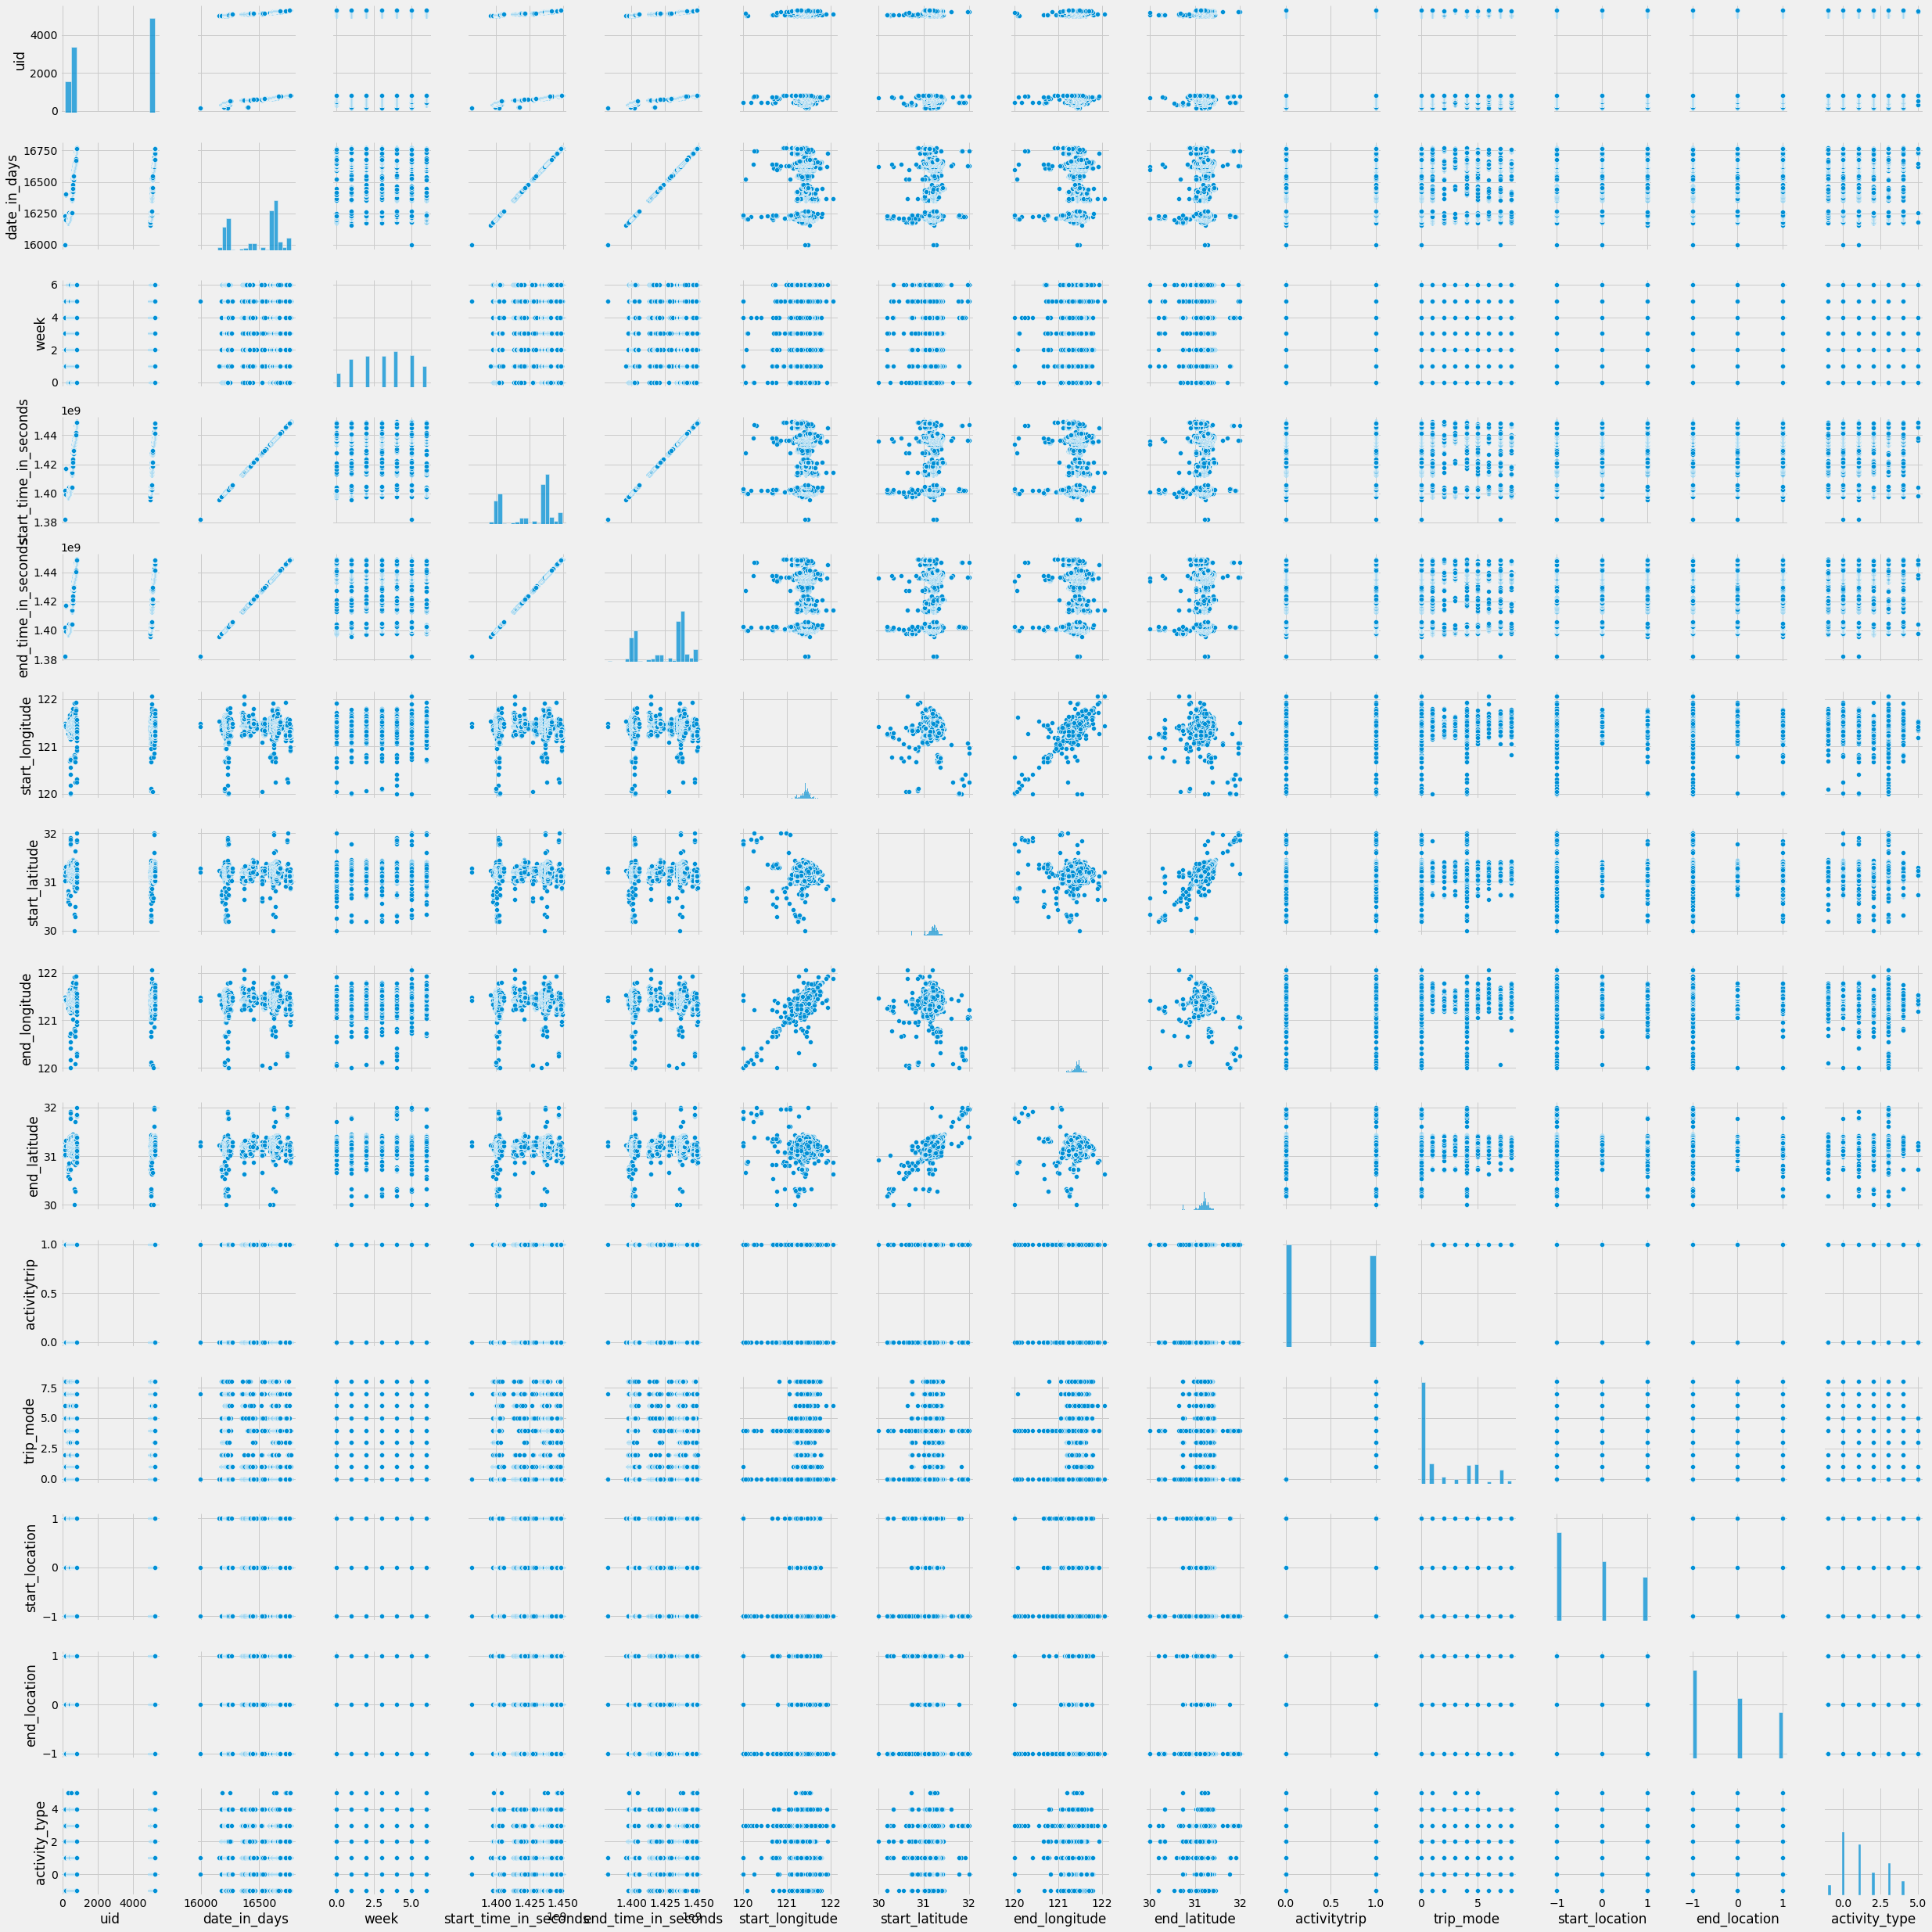

In [6]:
sns.pairplot(full_data)

activity_type           -0.381815
uid                     -0.066495
activitytrip            -0.039329
start_time_in_seconds   -0.033744
end_time_in_seconds     -0.033625
date_in_days            -0.033525
end_latitude            -0.030079
start_latitude          -0.028953
week                    -0.025488
trip_mode               -0.019798
start_longitude          0.029577
end_longitude            0.032796
start_location           0.524159
end_location             1.000000
Name: end_location, dtype: float64


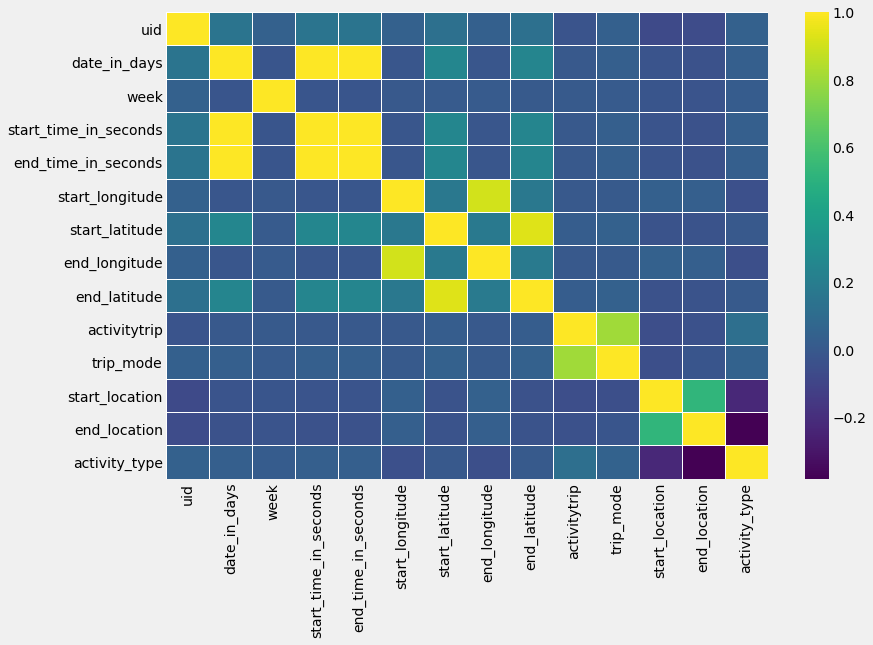

In [7]:
target_corr = full_data.corr()['end_location'].sort_values()
print(target_corr)
ax = sns.heatmap(full_data.corr(), annot=False, linewidths=0.5, cmap ='viridis')

<AxesSubplot:>

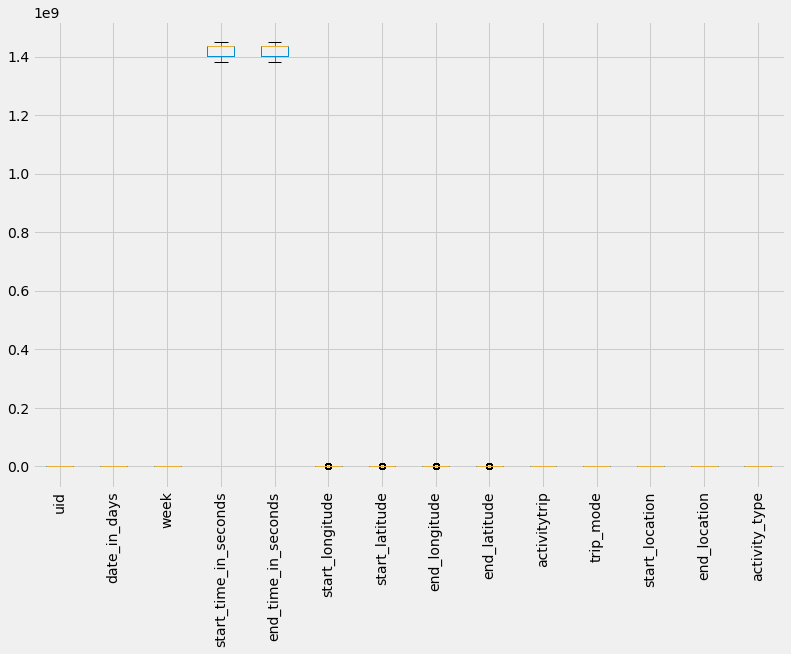

In [8]:
full_data.plot(kind='box', rot=90)

In [9]:
import geoplot as gplt
import geoplot.crs as gcrs
G = ox.graph_from_place('Shanghai, China', network_type='walk', simplify=True, retain_all=False, truncate_by_edge=True)

In [10]:
Gp = ox.project_graph(G)
Gc = ox.consolidate_intersections(Gp, rebuild_graph=True, tolerance=20, dead_ends=False)
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [11]:
nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 88564 entries, 91410243 to 8242010553
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   y             88564 non-null  float64 
 1   x             88564 non-null  float64 
 2   street_count  88564 non-null  int64   
 3   highway       3676 non-null   object  
 4   ref           68 non-null     object  
 5   geometry      88564 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 4.7+ MB


# Pre-Processing & Feature Engineering

## Trips

In [12]:
full_data.drop(['date_in_days','week','activitytrip','trip_mode','start_location','end_location','activity_type'], axis=1,inplace=True)
full_data['label'] = 1
y_trip = full_data.label
X_trip = full_data.copy().drop('label',axis=1)
# X_trip['user_tid'] = X_trip.sort_values(['uid','start_time_in_seconds']).groupby(['uid']).cumcount()+1
# he = ce.HashingEncoder(cols=['uid']).fit(X,y)
# new_data = he.transform(X)

In [13]:
X_trip.columns

Index(['uid', 'start_time_in_seconds', 'end_time_in_seconds',
       'start_longitude', 'start_latitude', 'end_longitude', 'end_latitude'],
      dtype='object')

In [14]:
def trip_transform_time(X):
        X = X.copy()
        # Engineer temporal features
        X['start_datetime'] = pd.to_datetime(X['start_time_in_seconds'],unit='s')
        X['end_datetime'] = pd.to_datetime(X['end_time_in_seconds'],unit='s')
        X['start_month'] = X['start_datetime'].dt.month
        X['start_day'] = X['start_datetime'].dt.day
        X['start_day_of_week'] = X['start_datetime'].dt.dayofweek
        X['start_hour_of_day'] = X['start_datetime'].dt.hour
        X['start_minute_of_hour'] = X['start_datetime'].dt.minute
        X['end_month'] = X['end_datetime'].dt.month
        X['end_day'] = X['end_datetime'].dt.day
        X['end_day_of_week'] = X['end_datetime'].dt.dayofweek
        X['end_hour_of_day'] = X['end_datetime'].dt.hour
        X['end_minute_of_hour'] = X['end_datetime'].dt.minute
#         X.drop(['start_time_in_seconds', 'end_time_in_seconds'], axis=1, inplace=True)
        X.drop(['start_datetime','end_datetime'], axis=1, inplace=True)
        return X
    
def calculate_great_circle_distance(start_latitude, start_longitude, end_latitude, end_longitude):
    pickup = [start_latitude, start_longitude]
    dropoff = [end_latitude, end_longitude]
    dist = distance.great_circle(pickup, dropoff).km
    return dist

def calculate_manhattan_distance(start_latitude, start_longitude, end_latitude, end_longitude):
    pickup = [start_latitude, start_longitude]
    dropoff_a = [start_latitude,end_longitude]
    dropoff_b = [end_latitude, start_longitude]
    distance_a = distance.great_circle(pickup, dropoff_a).km
    distance_b = distance.great_circle(pickup, dropoff_b).km
    return distance_a + distance_b

def calculate_bearing(start_latitude, start_longitude, end_latitude, end_longitude):
    d_lon = end_longitude-start_longitude
    y = math.sin(d_lon)*math.cos(end_latitude)
    x = math.cos(start_latitude)*math.sin(end_latitude) - math.sin(start_latitude)*math.cos(end_latitude)*math.cos(d_lon)
    bearing = math.atan2(y,x)
    if bearing < 0: 
        bearing+=2*math.pi
    return bearing

class TripTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, graph = None, hash=False):
        self.hash = hash
        self.he = None
        self.graph = graph
    
    def fit(self, X, y=None,graph=None, hash=False):
        if self.hash or hash:
            self.he = ce.HashingEncoder(cols=['uid']).fit(X)
        if graph:
            self.graph = graph
        return self
    
    def transform(self, X, y = None,hash=False):
        X_ = X.copy()
        X_['trip_id'] = X_.apply(lambda x: int(str(int(float(x.uid)))+str(int(float(str(x.start_time_in_seconds))))), axis=1)
        if self.hash or hash:
            if not self.he:
                print('Missing Hash Encoder, fitting on input data.')
                self.fit(X_,y)
            X_ = self.he.transform(X_)
        X_['duration_in_seconds'] = X_.apply(lambda x: x.end_time_in_seconds-x.start_time_in_seconds, axis=1)
        X_ = trip_transform_time(X_)
        X_['gc_dist'] = X_.apply(lambda x: calculate_great_circle_distance(x.start_latitude,\
                                                                           x.start_longitude,\
                                                                           x.end_latitude,\
                                                                           x.end_longitude),axis=1)
        X_['mn_dist'] = X_.apply(lambda x: calculate_manhattan_distance(x.start_latitude,\
                                                                        x.start_longitude,\
                                                                        x.end_latitude,\
                                                                        x.end_longitude),axis=1)
        X_['bearing'] = X_.apply(lambda x: calculate_bearing(x.start_latitude,\
                                                             x.start_longitude,\
                                                             x.end_latitude,\
                                                             x.end_longitude),axis=1)
        if self.graph:
            G = self.graph
            X_['starting_nn'],X_['starting_nn_dist'] = ox.distance.nearest_nodes(G, X_.start_longitude.to_numpy(), X_.start_latitude.to_numpy(),return_dist=True)
            X_['ending_nn'],X_['ending_nn_dist'] =  ox.distance.nearest_nodes(G, X_.start_longitude.to_numpy(), X_.end_latitude.to_numpy(),return_dist=True)
        return X_
    
    def fit_transform(self, X, y = None, graph=None,hash=False):
        self.fit(X,y,graph=graph,hash=hash)
        return self.transform(X,y,hash=hash)

In [15]:
TT = TripTransformer().fit(X_trip,graph=G)
trip_data = TT.transform(X_trip)

In [16]:
trip_data['label'] = y_trip

In [17]:
list(trip_data.columns)

['uid',
 'start_time_in_seconds',
 'end_time_in_seconds',
 'start_longitude',
 'start_latitude',
 'end_longitude',
 'end_latitude',
 'trip_id',
 'duration_in_seconds',
 'start_month',
 'start_day',
 'start_day_of_week',
 'start_hour_of_day',
 'start_minute_of_hour',
 'end_month',
 'end_day',
 'end_day_of_week',
 'end_hour_of_day',
 'end_minute_of_hour',
 'gc_dist',
 'mn_dist',
 'bearing',
 'starting_nn',
 'starting_nn_dist',
 'ending_nn',
 'ending_nn_dist',
 'label']

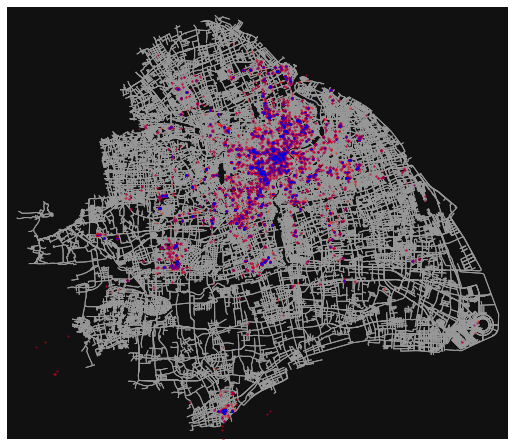

In [18]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(x=trip_data.start_longitude,y=trip_data.start_latitude, c='r', marker='.', alpha=0.5,s=10,zorder=3)
ax.scatter(x=trip_data.end_longitude,y=trip_data.end_latitude,c='b', marker='.',s=10,alpha=0.1,zorder=3)
fig.canvas.draw()

In [19]:
# trans_trips.boxplot(column='duration_in_seconds')

In [20]:
# # filtering outliers with zscore greater than 3 std
# from scipy import stats
# trip_data = trans_trips[(np.abs(stats.zscore(new_data.duration_in_seconds)) < 3)]
trip_data.describe()

,uid,start_time_in_seconds,end_time_in_seconds,start_longitude,start_latitude,end_longitude,end_latitude,trip_id,duration_in_seconds,start_month,start_day,start_day_of_week,start_hour_of_day,start_minute_of_hour,end_month,end_day,end_day_of_week,end_hour_of_day,end_minute_of_hour,gc_dist,mn_dist,bearing,starting_nn,starting_nn_dist,ending_nn,ending_nn_dist,label
count,10408.000000,1.040800e+04,1.040800e+04,10408.000000,10408.000000,10408.000000,10408.000000,1.040800e+04,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.00000,10408.000000,10408.000000,10408.000000,1.040800e+04,10408.000000,1.040800e+04,10408.000000,10408.0
mean,2842.034493,1.425239e+09,1.425243e+09,121.422001,31.192084,121.422014,31.191786,2.842177e+13,4243.676499,6.788624,16.001249,2.679573,8.344447,29.227998,6.790257,16.010473,2.679285,8.096656,29.98578,2.900622,3.650967,3.018098,2.595331e+09,664.131880,2.694939e+09,694.884995,1.0
std,2293.963747,1.704018e+07,1.704071e+07,0.133439,0.141343,0.133523,0.142475,2.293964e+13,8454.123554,2.202207,9.258483,1.842099,6.787444,17.481470,2.202646,9.263779,1.828725,5.983424,17.44137,7.482051,9.445600,1.905668,2.289282e+09,5920.030280,2.324264e+09,5918.840136,0.0
min,146.000000,1.382053e+09,1.382053e+09,120.000050,30.000058,120.000079,30.000203,1.461382e+12,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,6.110468e+07,1.078970,6.110467e+07,1.076532,1.0
25%,646.000000,1.402620e+09,1.402621e+09,121.377204,31.153523,121.378311,31.153198,6.461434e+12,408.000000,6.000000,8.000000,1.000000,3.000000,14.000000,6.000000,8.000000,1.000000,3.000000,15.00000,0.045604,0.056097,1.315101,6.405936e+08,37.868656,7.637263e+08,47.853964,1.0
50%,802.000000,1.435149e+09,1.435152e+09,121.433450,31.209346,121.433493,31.209479,8.021449e+12,1168.500000,7.000000,16.000000,3.000000,8.000000,30.000000,7.000000,16.000000,3.000000,8.000000,30.00000,0.220505,0.277105,3.060223,1.843657e+09,76.495756,1.870645e+09,90.316311,1.0
75%,5202.000000,1.438097e+09,1.438098e+09,121.484058,31.265852,121.484527,31.265647,5.202144e+13,3250.500000,8.000000,24.000000,4.000000,11.000000,44.000000,8.000000,24.000000,4.000000,11.000000,45.00000,2.391338,3.031269,4.643947,3.664787e+09,126.928941,4.074001e+09,145.825803,1.0
max,5281.000000,1.449234e+09,1.449235e+09,122.062761,31.999985,122.054907,31.999998,5.281145e+13,86398.000000,12.000000,31.000000,6.000000,23.000000,59.000000,12.000000,31.000000,6.000000,23.000000,59.00000,157.917356,206.588807,6.282447,8.728796e+09,113970.430032,8.728796e+09,119903.822522,1.0


In [21]:
# trip_data.boxplot(column='duration_in_seconds')

## Visit Data

In [22]:
start_df = trip_data[[x for x in list(trip_data.columns) if "end" not in x]]
end_df = trip_data[[x for x in list(trip_data.columns) if "start" not in x]]
end_df.columns = start_df.columns
visit_df = pd.concat([start_df,end_df])
print(list(visit_df.columns))
visit_df.drop(['gc_dist','mn_dist','bearing','duration_in_seconds'],axis=1,inplace=True)
visit_df = visit_df.rename(columns={"start_time_in_seconds":"timestamp",\
                        "start_longitude":"longitude",\
                        "start_latitude":"latitude",\
                        "start_month": "month",\
                        "start_day":"day_of_month",\
                        "start_day_of_week":"day_of_week",\
                        "start_hour_of_day":"hour_of_day",\
                        "start_minute_of_hour":"minute_of_hour",\
                                    "starting_nn_dist":"nn_dist",\
#                         "start_datetime":"datetime",\
                        "label":"trip_label",\
                                   "starting_nn":"nearest_node"})

['uid', 'start_time_in_seconds', 'start_longitude', 'start_latitude', 'trip_id', 'duration_in_seconds', 'start_month', 'start_day', 'start_day_of_week', 'start_hour_of_day', 'start_minute_of_hour', 'gc_dist', 'mn_dist', 'bearing', 'starting_nn', 'starting_nn_dist', 'label']


In [23]:
visit_df.columns

Index(['uid', 'timestamp', 'longitude', 'latitude', 'trip_id', 'month',
       'day_of_month', 'day_of_week', 'hour_of_day', 'minute_of_hour',
       'nearest_node', 'nn_dist', 'trip_label'],
      dtype='object')

In [24]:
print(visit_df.info())
visit_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20816 entries, 0 to 10407
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   uid             20816 non-null  int64  
 1   timestamp       20816 non-null  int64  
 2   longitude       20816 non-null  float64
 3   latitude        20816 non-null  float64
 4   trip_id         20816 non-null  int64  
 5   month           20816 non-null  int64  
 6   day_of_month    20816 non-null  int64  
 7   day_of_week     20816 non-null  int64  
 8   hour_of_day     20816 non-null  int64  
 9   minute_of_hour  20816 non-null  int64  
 10  nearest_node    20816 non-null  int64  
 11  nn_dist         20816 non-null  float64
 12  trip_label      20816 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 2.2 MB
None


,uid,timestamp,longitude,latitude,trip_id,month,day_of_month,day_of_week,hour_of_day,minute_of_hour,nearest_node,nn_dist,trip_label
0,146,1382053013,121.483090,31.281703,1461382053013,10,17,3,23,36,475846878,145.152762,1
1,146,1382053282,121.483192,31.281846,1461382053282,10,17,3,23,41,475846878,155.409566,1
2,146,1382066805,121.420343,31.207485,1461382066805,10,18,4,3,26,994212330,100.245102,1
3,146,1401056822,121.431495,31.202385,1461401056822,5,25,6,22,27,1844349528,66.184298,1
4,146,1401057000,121.431599,31.200593,1461401057000,5,25,6,22,30,1844349586,53.590932,1


In [25]:
visit_gdf = gpd.GeoDataFrame(visit_df, geometry=gpd.points_from_xy(visit_df.longitude, visit_df.latitude))
# temp_gdf.timestamp.describe()

In [26]:
visit_gdf.head()

,uid,timestamp,longitude,latitude,trip_id,month,day_of_month,day_of_week,hour_of_day,minute_of_hour,nearest_node,nn_dist,trip_label,geometry
0,146,1382053013,121.483090,31.281703,1461382053013,10,17,3,23,36,475846878,145.152762,1,POINT (121.48309 31.28170)
1,146,1382053282,121.483192,31.281846,1461382053282,10,17,3,23,41,475846878,155.409566,1,POINT (121.48319 31.28185)
2,146,1382066805,121.420343,31.207485,1461382066805,10,18,4,3,26,994212330,100.245102,1,POINT (121.42034 31.20749)
3,146,1401056822,121.431495,31.202385,1461401056822,5,25,6,22,27,1844349528,66.184298,1,POINT (121.43149 31.20239)
4,146,1401057000,121.431599,31.200593,1461401057000,5,25,6,22,30,1844349586,53.590932,1,POINT (121.43160 31.20059)


<AxesSubplot:>

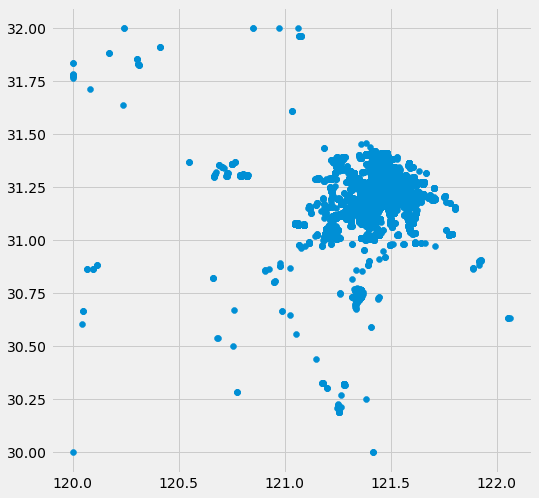

In [27]:
visit_gdf.plot()

In [28]:
# points_list = gpd.GeoSeries(gdf.geometry.to_list(),crs="EPSG:4326")
# points_proj = points_list.to_crs(Gp.graph['crs'])

In [29]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [30]:
# visit_df[]
# visit_df['nearest_node'] = ox.distance.nearest_nodes(G, visit_df.longitude.to_numpy(), visit_df.latitude.to_numpy())
nns = visit_df.nearest_node.values.tolist()
nodes['visits'] = nodes.index.map(lambda x: nns.count(x))
nodes.describe()

,y,x,street_count,visits
count,88564.000000,88564.000000,88564.000000,88564.000000
mean,31.152140,121.449299,2.906576,0.235039
std,0.150755,0.208567,0.990994,2.139832
min,30.691161,120.861980,1.000000,0.000000
25%,31.054229,121.313499,3.000000,0.000000
50%,31.192690,121.458895,3.000000,0.000000
75%,31.253830,121.570355,4.000000,0.000000
max,31.511308,121.972410,8.000000,191.000000


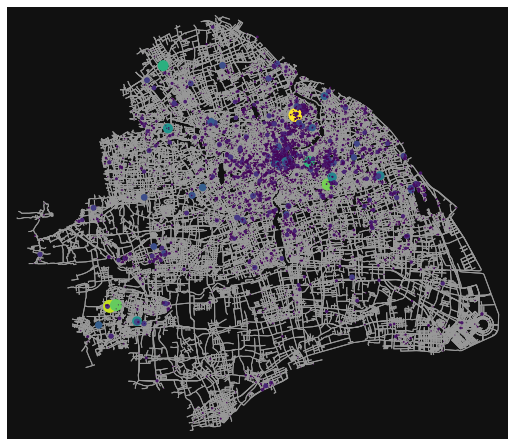

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [31]:
G2 = ox.graph_from_gdfs(nodes,edges)
# nc = ox.plot.get_node_colors_by_attr(G2,'visits', num_bins=20)
ox.plot_graph(G2,node_size=nodes['visits'], node_color=nodes['visits'])

In [32]:
visit_df = visit_df.copy().drop(['geometry','trip_id'],axis=1)
y_train = visit_df.pop('trip_label')
anomaly_fraction = (2.8/1000)*(7/10)/365 # prevalence of kidnapping by prevalence of leaving the home

In [33]:
import random
def visit_transform_time(visit=None, uid=None, timestamp=None, coords=tuple):
    if isinstance(visit,pd.DataFrame):
        X = visit.copy()
    elif isinstance(visit,list):
        data = {'uid':visit[0],'timestamp':visit[1],'longitude':visit[2],'latitude':visit[3]}
    elif not visit:
        data = {'uid':uid,'timestamp':timestamp,'longitude':coords[1],'latitude':coords[0]}
    X = pd.DataFrame(data, index=[0])
    X['timestamp_datetime'] = pd.to_datetime(X['timestamp'],unit='s')
    X['month'] = X['timestamp_datetime'].dt.month
    X['day_of_month'] = X['timestamp_datetime'].dt.day
    X['day_of_week'] = X['timestamp_datetime'].dt.dayofweek
    X['hour_of_day'] = X['timestamp_datetime'].dt.hour
    X['minute_of_hour'] = X['timestamp_datetime'].dt.minute
    X.drop('timestamp_datetime', axis=1, inplace=True)
    return X
    
class VisitTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, graph = None, hash_bool=False, he=None):
        self.hash_bool = hash_bool
        self.he = he
        if he:
            hash_bool == True
            
        self.graph = graph
    
    def fit(self, X, y=None,graph=None, hash_bool=False, he=None):
        x = X.copy()
        if 'geometry' in X.columns:
            x.drop('geometry', axis=1, inplace=True)
        if self.hash_bool or hash_bool and not self.he:
            self.he = ce.HashingEncoder(cols=['uid']).fit(x)
        if graph:
            self.graph = graph
        return self
    
    def transform(self, X, y = None,hash_bool=False):
        X_ = X.copy()
        if isinstance(X, pd.DataFrame):
            if 'geometry' in X.columns:
                x.drop('geometry', axis=1, inplace=True)
        X_ = visit_transform_time(visit=X_)
        if self.hash_bool or hash_bool:
            if not self.he:
                print('Missing Hash Encoder, fitting on input data.')
                self.fit(X_,y)
            X_ = self.he.transform(X_)
        if self.graph:
            G = self.graph
            X_['nearest_node'],X_['nn_dist'] = ox.distance.nearest_nodes(G, X_.longitude.to_numpy(), X_.latitude.to_numpy(),return_dist=True)
        return X_
    
    def fit_transform(self, X, y = None, graph=None,hash_bool=False):
        self.fit(X,y,graph=graph,hash_bool=hash_bool)
        return self.transform(X,y,hash_bool=hash_bool)

def generate_visit(visits_df, current_kind='inlier', new_user=False, new_ids=None):
            if new_user:
                uid = visits_df.uid.unique().max() + 1
                while uid in new_ids:
                    uid += 1
                new_ids.append(uid)
                user_df = visits_df.sample(n=random.randint(0,50))
            else:
                uid = random.choice(visits_df.uid.unique())
                user_df = visits_df[visits_df.uid == uid]
            if current_kind == 'inlier':
                if not new_user:
                    visits_df = user_df
                temp_visit = visits_df.sample()
                new_lat = temp_visit.latitude.values
                new_lng = temp_visit.longitude.values
                label=1
            new_timestamp = None
            while not new_timestamp or new_timestamp in user_df.timestamp:
                new_timestamp = random.randint(visits_df.timestamp.min(), visits_df.timestamp.max()+31536000)
            if current_kind == 'cross':
                temp_visit = visits_df[visits_df.uid != uid].sample()
                new_lat = temp_visit.latitude.values
                new_lng = temp_visit.longitude.values
                label = 0
            else:
                lat_min = visits_df.latitude.min()
                lat_max = visits_df.latitude.max()
                lng_min = visits_df.longitude.min()
                lng_max = visits_df.longitude.max()
                new_lat = float(random.choice([random.uniform(lat_max, 90), random.uniform(-90, lat_min)]))
                new_lng = float(random.choice([random.uniform(lng_max, 180), random.uniform(-180, lng_min)]))
                label = 0
            new_visit = [uid,new_timestamp,new_lat,new_lng]
            return new_visit, label, new_ids 

def generate_visits(input_df=None, kind='any', N=1,new_user=False):
    visits_df = input_df.copy()
    new_visits = []
    new_ids = []
    labels = []
    for i in range(N):
        if kind == 'any':
            current_kind = random.choice(['inlier','cross','anomaly'])
        else:
            current_kind = kind
        new_visit, label, new_ids = generate_visit(visits_df, current_kind, new_user, new_ids)
        new_visits.append(new_visit)
        labels.append(label)
    if new_user:
        print(f'New users added: {new_ids}')
    return new_visits, labels

In [35]:
VT = VisitTransformer(graph=G)
VT.fit(visit_df)

VisitTransformer(graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x00000189F99BD9D0>)

In [85]:
new_visits, y_valid = generate_visits(visit_df,N=2000)

In [86]:
outlier_df = pd.concat([VT.transform(new_visit) for new_visit in new_visits])

In [87]:
he = ce.HashingEncoder(cols=['uid','nearest_node']).fit(visit_df)

In [88]:
visit_normal = he.transform(visit_df)
# X_train = pd.get_dummies(data=visit_normal, columns=['month','day_of_week','hour_of_day'])
visit_abnormal = he.transform(outlier_df)
# X_test = pd.get_dummies(data=visit_normal, columns=['month','day_of_week','hour_of_day'])

## Model

In [89]:
X_train, X_test = train_test_split(visit_normal,random_state=13)
# X_train = visit_normal
X_outliers = visit_abnormal
y_outliers = [-1]*len(y_valid)
y_train = [1]*X_train.shape[0]
y_test = [1]*X_train.shape[0]

In [90]:
ec = EllipticEnvelope(support_fraction=1.,contamination=anomaly_fraction)
rc = EllipticEnvelope(contamination=anomaly_fraction)
IF = IsolationForest(contamination=anomaly_fraction)
ocsvm = OneClassSVM(nu=anomaly_fraction,gamma='auto')
models = [('ec',ec),('rc',rc),('if',IF),('ocsvm',ocsvm)]

## Compare models trained on 2 Components

In [91]:
# perform normalization and PCA and output components to illustrate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('normalizer', Normalizer()),
        ('reduce_dim', PCA(n_components=2)),
        ])
# ss = StandardScaler.fit(X_train)
# X_normalized = pd.DataFrame(normalize(ss.transform(X_train)))
pipe.fit(X_train)

X_train_pc = pipe.transform(X_train)
X_train_principal = pd.DataFrame(X_train_pc,columns = ['P1', 'P2'])

X_test_pc = pipe.transform(X_test)
X_test_principal = pd.DataFrame(X_test_pc, columns=['P1','P2'])

X_out_pc = pipe.transform(X_outliers)
X_outlier_principal = pd.DataFrame(X_out_pc, columns = ['P1','P2'])

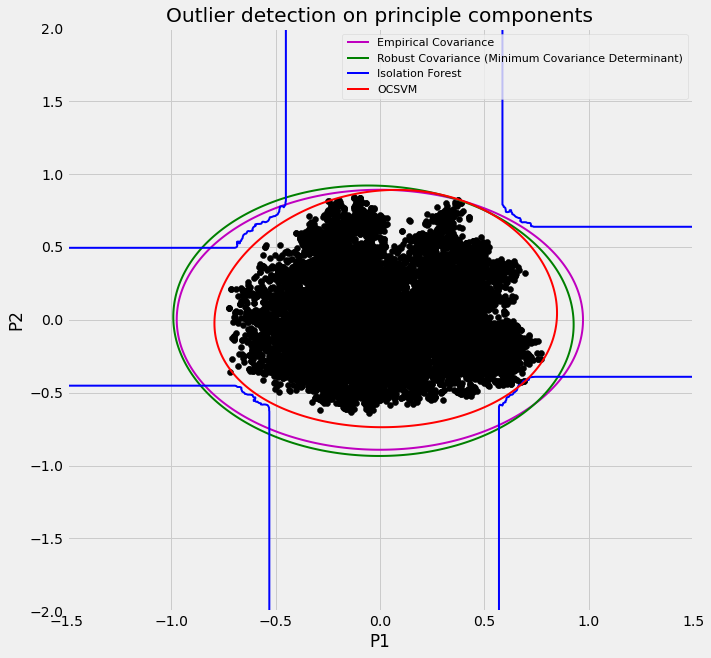

In [92]:
# model selection by visualizing performance on principle components
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
import matplotlib
classifiers = {
    "Empirical Covariance": ec,
    "Robust Covariance (Minimum Covariance Determinant)":
    rc,
    "Isolation Forest" : IF,
    "OCSVM": ocsvm}
colors = ['m', 'g', 'b', 'r']
legend1 = {}
legend2 = {}

xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 500), np.linspace(-2, 2, 500))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1, figsize=(10,10))
    clf.fit(X_train_principal)
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    legend1[clf_name] = plt.contour(
        xx, yy, Z, levels=[0], linewidths=2, colors=colors[i])

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(1, figsize=(10,10))# two clusters
plt.title("Outlier detection on principle components")
plt.scatter(X_train_principal['P1'], X_train_principal['P2'], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.xlim((xx.min(), xx.max()))
plt.ylim((yy.min(), yy.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0],
            legend1_values_list[3].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2], legend1_keys_list[3]),
           loc="upper right",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.ylabel("P2")
plt.xlabel("P1")

plt.show()

##  Fit on 99% components

In [93]:
# perform scalingand PCA on each relevant dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA(n_components=0.99)),
        ])
# ss = StandardScaler.fit(X_train)
# X_normalized = pd.DataFrame(normalize(ss.transform(X_train)))
pipe.fit(X_train)

X_train_pc = pipe.transform(X_train)
# X_train_principal = pd.DataFrame(X_train_pc,columns = ['P1', 'P2'])

X_test_pc = pipe.transform(X_test)
# X_test_principal = pd.DataFrame(X_test_pc, columns=['P1','P2'])

X_out_pc = pipe.transform(X_outliers)
# X_outlier_principal = pd.DataFrame(X_out_pc, columns = ['P1','P2'])

In [104]:
print(X_train_pc.shape)

(15612, 16)


## Evaluation of Models

In [94]:
train_pred_dict = {}
test_pred_dict = {}
outlier_pred_dict = {}
for name, clf in models:
    clf.fit(X_train_pc)
    y_pred_train = clf.predict(X_train_pc)
    y_pred_test = clf.predict(X_test_pc)
    y_pred_outliers = clf.predict(X_out_pc)
    train_pred_dict[name] = y_pred_train
    test_pred_dict[name] = y_pred_test
    outlier_pred_dict[name] = y_pred_outliers
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size
    n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
    print(f'{name} train error: {n_error_train} | test error: {n_error_test} | outlier error: {n_error_outliers}')

ec train error: 1 | test error: 0 | outlier error: 0
rc train error: 1 | test error: 0 | outlier error: 0
if train error: 1 | test error: 0 | outlier error: 0
ocsvm train error: 1362 | test error: 460 | outlier error: 0


In [95]:
train_results = pd.DataFrame(train_pred_dict)
train_results['minimum'] = train_results.min(axis=1)
train_results['avg'] = train_results.mean(axis=1)
train_results['maximum'] = train_results.max(axis=1)
test_results = pd.DataFrame(test_pred_dict)
test_results['minimum'] = test_results.min(axis=1)
test_results['avg'] = test_results.mean(axis=1)
test_results['maximum'] = test_results.max(axis=1)
outlier_results = pd.DataFrame(outlier_pred_dict)
outlier_results['minimum'] = outlier_results.min(axis=1)
outlier_results['avg'] = outlier_results.mean(axis=1)
outlier_results['maximum'] = outlier_results.max(axis=1)
for sumstat in ['minimum','avg','maximum']:
    y_pred_train = train_results
    y_pred_test = clf.predict(X_test_pc)
    y_pred_outliers = clf.predict(X_out_pc)
    train_pred_dict[name] = y_pred_train
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size
    n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

In [96]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
train_error_df = train_results[(train_results == -1).any(axis=1)]
X_train[X_train.index.isin(train_error_df.index)]

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,timestamp,longitude,latitude,month,day_of_month,day_of_week,hour_of_day,minute_of_hour,nn_dist
15170,0,0,0,1,1,0,0,0,1446545472,121.576398,31.110965,11,3,1,10,11,31.000932
477,0,1,0,0,0,0,1,0,1398681238,121.341132,30.730583,4,28,0,10,33,208.507895
188,0,0,0,0,0,1,1,0,1397865097,121.339397,30.725539,4,18,4,23,51,85.793476
10697,0,0,1,0,0,0,1,0,1397744656,121.334404,30.729497,4,17,3,14,24,164.240842
2587,0,0,1,0,0,0,1,0,1433599958,121.402640,31.276082,6,6,5,14,12,207.553934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10974,0,0,0,0,2,0,0,0,1401457151,121.428644,31.200550,5,30,4,13,39,4.694123
5400,0,1,0,0,0,1,0,0,1400254374,121.501438,31.269794,5,16,4,15,32,102.780044
11424,0,0,1,0,1,0,0,0,1400831262,121.327438,31.169656,5,23,4,7,47,13.253827
12237,0,0,0,1,0,0,0,1,1412836658,121.261087,31.008540,10,9,3,6,37,53.547160


In [97]:
from sklearn.metrics import make_scorer, f1_score

In [101]:
from sklearn.metrics import classification_report
for column in train_results.columns:
    print(f'{column} results')
    y_true = [-1]*len(outlier_results.index)
    y_pred = outlier_results[name].values
    tp, fn, fp, tn = confusion_matrix(y_true,y_pred,labels=[-1,1]).reshape(-1)
    print('Outcome values : \n', tp, fn, fp, tn)
    print(classification_report(y_true, y_pred))

ec results
Outcome values : 
 2000 0 0 0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

rc results
Outcome values : 
 2000 0 0 0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

if results
Outcome values : 
 2000 0 0 0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ocsvm results
Outcome values : 
 2000 0 0 0
              